In [28]:
!pip install mysql-connector-python

DEPRECATION: dbapi 0.0.14 has a non-standard dependency specifier requests>. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dbapi or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [101]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('geolocation.csv','geolaction'),
    ('products.csv', 'products'),
    ('order_items.csv','order_item'),
    ('payments.csv', 'payments'), # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:\\Users\\HP\\OneDrive\\Desktop\\ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector
%matplotlib inline

Basic Queries
1. List all unique cities where customers are located.
2. Count the number of orders placed in 2017.
3. Find the total sales per category.
4. Calculate the percentage of orders that were paid in installments.
5. Count the number of customers from each state. 

Intermediate Queries
1. Calculate the number of orders per month in 2018.
2. Find the average number of products per order, grouped by customer city.
3. Calculate the percentage of total revenue contributed by each product category.
4. Identify the correlation between product price and the number of times a product has been purchased.
5. Calculate the total revenue generated by each seller, and rank them by revenue.

Advanced Queries
1. Calculate the moving average of order values for each customer over their order history.
2. Calculate the cumulative sales per month for each year.
3. Calculate the year-over-year growth rate of total sales.
4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
5. Identify the top 3 customers who spent the most money in each year.

In [103]:
db = mysql.connector.connect(host="localhost",
                             username = "root",
                             password ="12345",
                             database = "ecommerce")

In [104]:
cur =db.cursor()

1. List all unique cities where customers are located.

In [105]:
query = """ select distinct(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

2. Count the number of orders placed in 2017.


In [36]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
data[0][0]

180404

3. Find the total sales per category.

In [46]:
query = """ 
select upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_item on
products.product_id = order_item.product_id
join payments on
payments.order_id = order_item.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["category","sales"])
df_sorted = df.sort_values(by='sales',ascending=False)
df_sorted

,category,sales
3,BED TABLE BATH,6850214.68
11,HEALTH BEAUTY,6629492.48
5,COMPUTER ACCESSORIES,6341321.79
1,FURNITURE DECORATION,5720705.57
15,WATCHES PRESENT,5716866.71
...,...,...
72,PC GAMER,8697.72
66,HOUSE COMFORT 2,6842.16
69,CDS MUSIC DVDS,4797.72
71,FASHION CHILDREN'S CLOTHING,3142.68


<Axes: xlabel='category', ylabel='sales'>

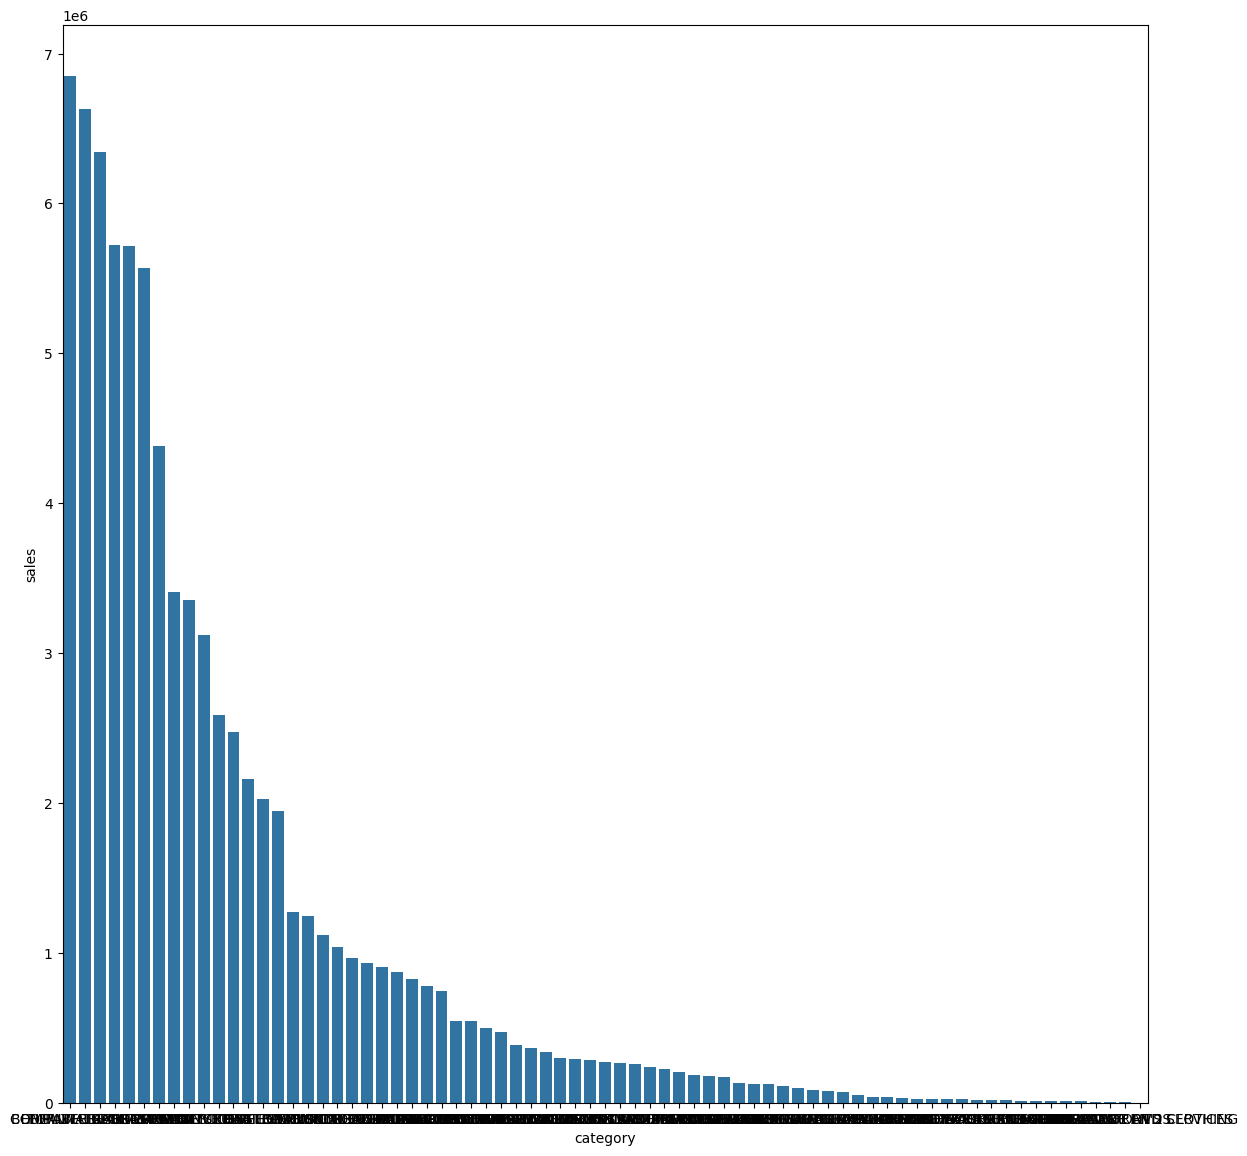

In [48]:
plt.figure(figsize=(14,14))
sns.barplot(data=df_sorted,x='category',y='sales')

4. Calculate the percentage of orders that were paid in installments.

In [55]:
query = """ 
select (sum(case when payment_installments > 1 then 1 else 0 end))/count(*)*100 from payments
"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('49.4176'),)]

5. Count the number of customers from each state. 

In [67]:
query = """ 
select customer_state , count(customer_id) from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df1 =pd.DataFrame(data, columns=["state","customer_count"])
df1

,state,customer_count
0,SP,166984
1,SC,14548
2,MG,46540
3,PR,20180
4,RJ,51408
5,RS,21864
6,PA,3900
7,GO,8080
8,ES,8132
9,BA,13520


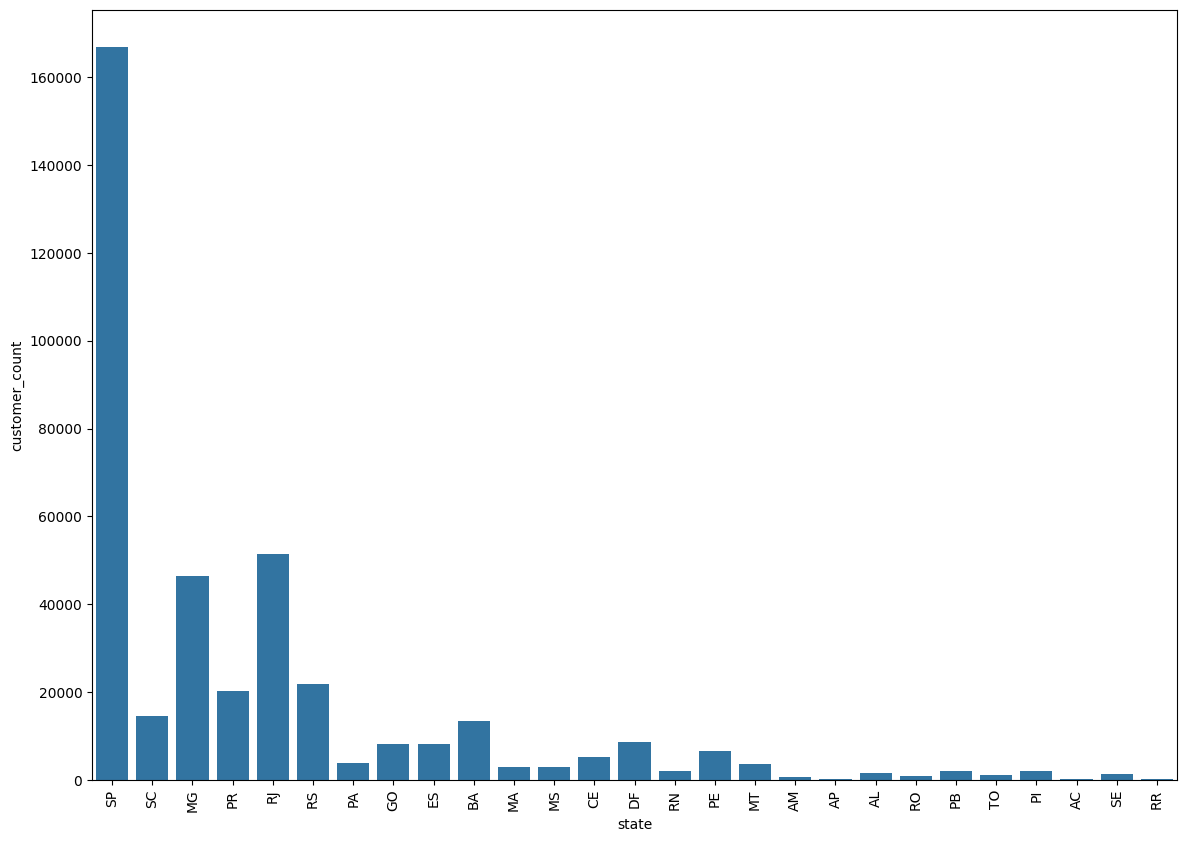

In [68]:
plt.figure(figsize=(14,10))
sns.barplot(data=df1,x='state',y='customer_count')
plt.xticks(rotation =90)
plt.show()

6. Calculate the number of orders per month in 2018.

In [73]:
query = """ 
select monthname(order_purchase_timestamp) month,count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by month
"""
cur.execute(query)
data = cur.fetchall()
df2 = pd.DataFrame(data, columns=["month","order_count"])
df2

,month,order_count
0,July,25168
1,August,26048
2,February,26912
3,June,24668
4,March,28844
5,January,29076
6,May,27492
7,April,27756
8,September,64
9,October,16


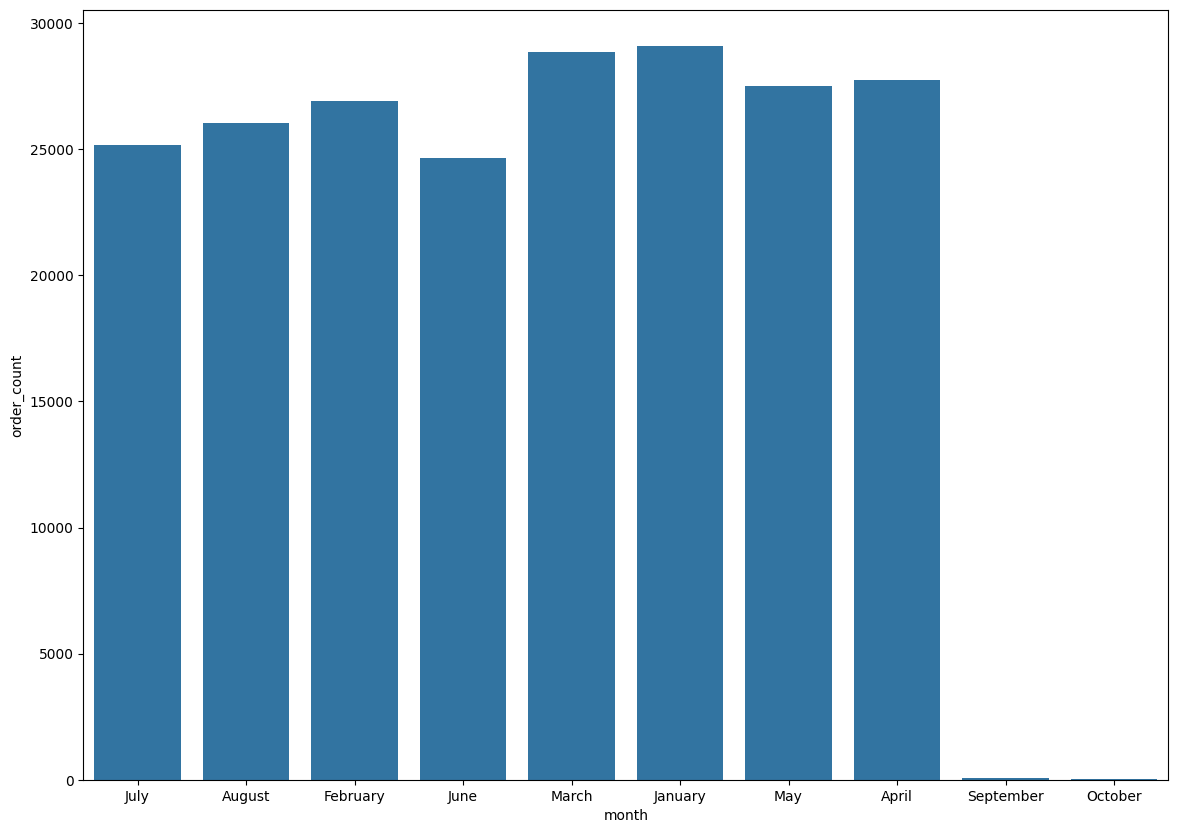

In [76]:
plt.figure(figsize=(14,10))
sns.barplot(data=df2,x='month',y='order_count')
plt.show()

Find the average number of products per order, grouped by customer city.

In [80]:
query = """ 
with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_item.order_id) as oc
from orders join order_item on
orders.order_id = order_item.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""
cur.execute(query)
data = cur.fetchall()
df3 = pd.DataFrame(data,columns=["customer_city","average_order"])
df3

,customer_city,average_order
0,treze tilias,5.09
1,indaial,4.46
2,sao jose dos campos,4.55
3,sao paulo,4.62
4,porto alegre,4.70
...,...,...
4105,guairaca,8.00
4106,sambaiba,4.00
4107,japaratuba,4.00
4108,tuiuti,4.00


8. Calculate the percentage of total revenue contributed by each product category.

In [96]:
query = """ 
select upper(products.product_category) category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_item on
products.product_id = order_item.product_id
join payments on
payments.order_id = order_item.order_id
group by category order by sales
"""
cur.execute(query)
data = cur.fetchall()
data

[('INSURANCE AND SERVICES', 0.01),
 ("FASHION CHILDREN'S CLOTHING", 0.02),
 ('CDS MUSIC DVDS', 0.03),
 ('HOUSE COMFORT 2', 0.04),
 ('PC GAMER', 0.05),
 ('ARTS AND CRAFTS', 0.06),
 ('FLOWERS', 0.06),
 ('LA CUISINE', 0.07),
 ('FASHION SPORT', 0.09),
 ('KITCHEN PORTABLE AND FOOD COACH', 0.11),
 ('HYGIENE DIAPERS', 0.11),
 ("FASHION WOMEN'S CLOTHING", 0.13),
 ('PARTY ARTICLES', 0.15),
 ('CITTE AND UPHACK FURNITURE', 0.15),
 ('SONG', 0.17),
 ('IMPORTED BOOKS', 0.17),
 ('BLU RAY DVDS', 0.2),
 ('CINE PHOTO', 0.24),
 ('IMAGE IMPORT TABLETS', 0.25),
 ('FASHION UNDERWEAR AND BEACH FASHION', 0.32),
 ("FASHION MEN'S CLOTHING", 0.43),
 ('CHRISTMAS ARTICLES', 0.47),
 ('CONSTRUCTION TOOLS TOOLS', 0.53),
 ('TECHNICAL BOOKS', 0.62),
 ('DRINK FOODS', 0.68),
 ('ART', 0.77),
 ('FURNITURE', 0.79),
 ('FASHION CALCADOS', 0.81),
 ('CONSTRUCTION TOOLS GARDEN', 1.06),
 ('MARKET PLACE', 1.13),
 ('FOODS', 1.16),
 ('HOUSE PASTALS OVEN AND CAFE', 1.28),
 ('INDUSTRY COMMERCE AND BUSINESS', 1.42),
 ('AUDIO', 1.51),
 

9. Identify the correlation between product price and the number of times a product has been purchased.

In [109]:
query = """ 
select products.product_category,
count(order_item.product_id),
round(avg(order_item.price),2)
from products join order_item
on products.product_id = order_item.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
data
df5 = pd.DataFrame(data,columns=["products","no of times bought","prize"])

arr1 = df5["no of times bought"]
arr2 = df5["prize"]
np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

10. Calculate the total revenue generated by each seller, and rank them by revenue.

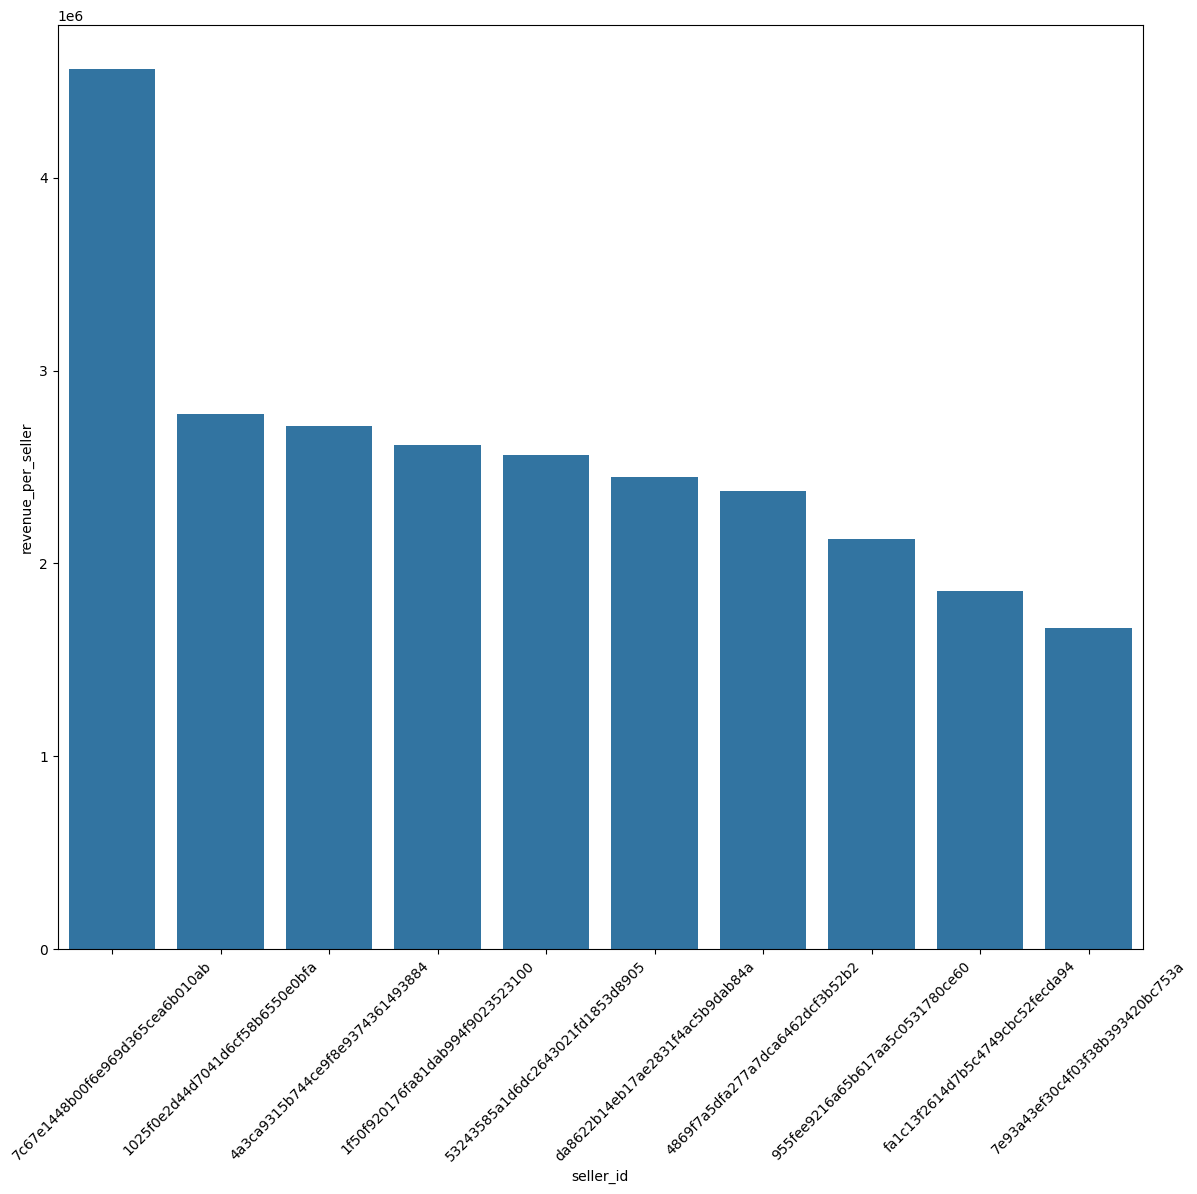

In [115]:
query = """ 
select *,dense_rank() over (order by revenue desc) as rn from
(select order_item.seller_id,round(sum(payments.payment_value),2) revenue
from order_item join payments
on order_item.order_id = payments.order_id
group by order_item.seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df6 = pd.DataFrame(data,columns =["seller_id","revenue_per_seller","rank"])

df6 =df6.head(10)

plt.figure(figsize=(14,12))
sns.barplot(data=df6,x='seller_id',y='revenue_per_seller')
plt.xticks(rotation =45)
plt.show()

11.Calculate the moving average of order values for each customer over their order history.

In [119]:
query = """ 
select orders.customer_id,orders.order_purchase_timestamp ,payments.payment_value payment
from payments join orders
on payments.order_id = orders = order_id
"""
cur.execute(query)
data = cur.fetchall()
data

ProgrammingError: 1054 (42S22): Unknown column 'orders' in 'on clause'